In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

In [3]:
# Debugging function
def debug_info(message, variable):
    print(f"[DEBUG] {message}: Type: {type(variable)}, Shape: {np.shape(variable)}")

In [4]:
# Load dataset
try:
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project-1/Dataset/Sequences (2).csv")
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

Dataset loaded successfully.


In [5]:
# Convert sequences and coefficients from string to list
df["Sequence"] = df["Sequence"].apply(eval)
df["Coefficients"] = df["Coefficients"].apply(eval)

# Extract features and targets
sequences = df["Sequence"].tolist()
next_values = df["Next Value"].values.reshape(-1, 1)
sequence_types = df["Type"].values
coefficients = df["Coefficients"].tolist()

# Debugging dataset contents
debug_info("Sample sequence", sequences[0])
debug_info("Next values", next_values)
debug_info("Sequence types", sequence_types)
debug_info("Coefficients", np.array(coefficients, dtype=object))

[DEBUG] Sample sequence: Type: <class 'list'>, Shape: (3,)
[DEBUG] Next values: Type: <class 'numpy.ndarray'>, Shape: (100000, 1)
[DEBUG] Sequence types: Type: <class 'numpy.ndarray'>, Shape: (100000,)
[DEBUG] Coefficients: Type: <class 'numpy.ndarray'>, Shape: (100000,)


In [6]:
# Split into training and testing sets
train_seq, test_seq, train_next, test_next, train_type, test_type, train_coeff, test_coeff = train_test_split(
    sequences, next_values, sequence_types, coefficients, test_size=0.2, random_state=42
)

In [7]:
# Preprocessing for Next Value Prediction (Model 1)
max_seq_length = 20
train_padded = pad_sequences(train_seq, maxlen=max_seq_length, padding="post")
test_padded = pad_sequences(test_seq, maxlen=max_seq_length, padding="post")
debug_info("Padded training sequences", train_padded)

[DEBUG] Padded training sequences: Type: <class 'numpy.ndarray'>, Shape: (80000, 20)


In [8]:
print(train_padded[:5])

[[ 10  40 160   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  9  15  23  33   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  2   3   5   7  11  13  17  19  23  29  31  37  41  43  47   0   0   0
    0   0]
 [  2   3   5   7  11  13   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [ 11  40 109   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]


In [ ]:
# Fit and transform using MinMaxScaler
seq_scaler = MinMaxScaler()
train_padded_scaled = seq_scaler.fit_transform(train_padded)
test_padded_scaled = seq_scaler.transform(test_padded)
debug_info("Scaled training sequences", train_padded_scaled)

[DEBUG] Scaled training sequences: Type: <class 'numpy.ndarray'>, Shape: (80000, 20)


In [ ]:
print(train_padded_scaled[:2])

[[0.20353982 0.43548387 0.64980545 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.19469027 0.23387097 0.11673152 0.0264     0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [ ]:
print(train_padded_scaled.min(), train_padded_scaled.max())

0.0 1.0


In [9]:
# Normalize next values
train_next_transformed = np.log1p(train_next)  # Apply log transform

next_scaler = StandardScaler()
train_next_scaled = next_scaler.fit_transform(train_next_transformed.reshape(-1, 1))
test_next_transformed = np.log1p(test_next)  # Apply log transform to test data
test_next_scaled = next_scaler.transform(test_next_transformed.reshape(-1, 1))

debug_info("Scaled training next values", train_next_scaled)

[DEBUG] Scaled training next values: Type: <class 'numpy.ndarray'>, Shape: (80000, 1)


In [10]:
print(train_next_scaled[:3])

[[ 0.79947527]
 [-0.96006601]
 [-0.85297111]]


In [ ]:
print(test_next_scaled[:10])

[[-0.84071549]
 [-0.00224659]
 [-0.8286807 ]
 [-0.91786802]
 [ 0.62277847]
 [ 0.88631399]
 [ 1.34881817]
 [ 1.26191589]
 [ 0.50587295]
 [ 1.09584505]]


In [ ]:
print(train_next_scaled.min(), train_next_scaled.max())

-2.4423002268205614 3.395503171367116


In [11]:
# Preprocessing for Sequence Type Classification (Model 2)
label_encoder = LabelEncoder()
train_type_labels = label_encoder.fit_transform(train_type)
test_type_labels = label_encoder.transform(test_type)
debug_info("Encoded training sequence types", train_type_labels)

[DEBUG] Encoded training sequence types: Type: <class 'numpy.ndarray'>, Shape: (80000,)


In [12]:
print(train_type_labels[:3])

[2 4 3]


In [ ]:
# Preprocessing for Coefficients Prediction (Model 3)
max_coeff_length = max(len(c) for c in coefficients)
train_coeff_padded = pad_sequences(train_coeff, maxlen=max_coeff_length, padding="post", dtype="float32")
test_coeff_padded = pad_sequences(test_coeff, maxlen=max_coeff_length, padding="post", dtype="float32")
debug_info("Padded training coefficients", train_coeff_padded)


[DEBUG] Padded training coefficients: Type: <class 'numpy.ndarray'>, Shape: (80000, 4)


In [ ]:
print(train_coeff_padded.min(), train_coeff_padded.max())
print(train_coeff_padded)

-10.0 100.0
[[10.  4.  0.  0.]
 [ 1.  3.  5.  0.]
 [ 0.  0.  0.  0.]
 ...
 [10.  5.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 2.  5.  9.  0.]]


In [ ]:
# Fit and transform coefficients using MinMaxScaler
coeff_scaler = MinMaxScaler()
train_coeff_scaled = coeff_scaler.fit_transform(train_coeff_padded)
test_coeff_scaled = coeff_scaler.transform(test_coeff_padded)
debug_info("Scaled training coefficients", train_coeff_scaled)

[DEBUG] Scaled training coefficients: Type: <class 'numpy.ndarray'>, Shape: (80000, 4)


In [ ]:
print(train_coeff_scaled[:2])

[[0.09999999 0.5        0.16666667 0.5       ]
 [0.01       0.4166667  0.5833334  0.5       ]]


In [ ]:
print(train_coeff_scaled.min(), train_coeff_scaled.max())

0.0 1.0


In [ ]:
# Save preprocessed data
preprocessed_data = {
    "train_padded_scaled": train_padded_scaled,
    "test_padded_scaled": test_padded_scaled,
    "train_next_scaled": train_next_scaled,
    "test_next_scaled": test_next_scaled,
    "train_type_labels": train_type_labels,
    "test_type_labels": test_type_labels,
    "train_coeff_scaled": train_coeff_scaled,
    "test_coeff_scaled": test_coeff_scaled,
    "seq_scaler": seq_scaler,
    "next_scaler": next_scaler,
    "coeff_scaler": coeff_scaler,
    "label_encoder": label_encoder,
}

In [ ]:
try:
    with open("/content/drive/MyDrive/Colab Notebooks/Project-1/Scalers/preprocessed_data.pkl", "wb") as f:
        pickle.dump(preprocessed_data, f)
    print("Preprocessing complete! Data saved as 'preprocessed_data.pkl'")
except Exception as e:
    print(f"Error saving preprocessed data: {e}")

Preprocessing complete! Data saved as 'preprocessed_data.pkl'


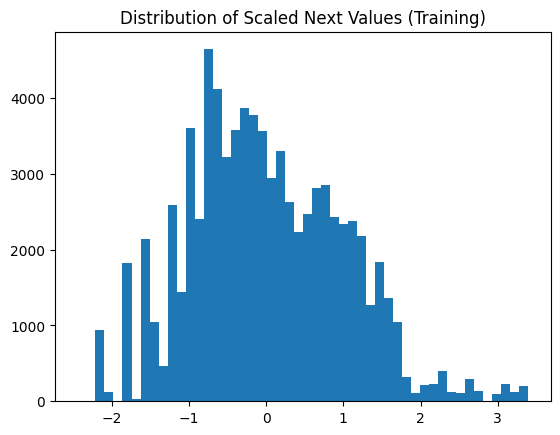

In [ ]:
import matplotlib.pyplot as plt

plt.hist(train_next_scaled, bins=50)
plt.title("Distribution of Scaled Next Values (Training)")
plt.show()

In [ ]:
import numpy as np

print("Next Values Stats:")
print(f"Min: {np.min(train_next_scaled)}, Max: {np.max(train_next_scaled)}")
print(f"Mean: {np.mean(train_next_scaled)}, Std Dev: {np.std(train_next_scaled)}")


Next Values Stats:
Min: 0.0, Max: 1.0
Mean: 0.5016925758668593, Std Dev: 0.2865842192688453


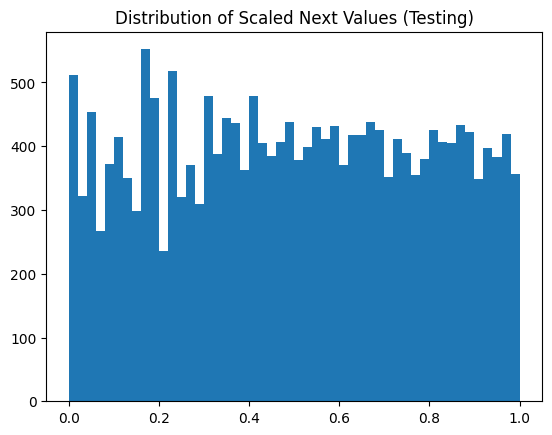

In [ ]:
import matplotlib.pyplot as plt

plt.hist(test_next_scaled, bins=50)
plt.title("Distribution of Scaled Next Values (Testing)")
plt.show()

In [ ]:
import numpy as np

print("Next Values Stats:")
print(f"Min: {np.min(test_next_scaled)}, Max: {np.max(test_next_scaled)}")
print(f"Mean: {np.mean(test_next_scaled)}, Std Dev: {np.std(test_next_scaled)}")

Next Values Stats:
Min: 0.0, Max: 1.0
Mean: 0.5007572107037906, Std Dev: 0.2863401256738646


In [ ]:
print(f"Next Scaler Mean: {next_scaler.mean_}, Variance: {next_scaler.var_}")

Next Scaler Mean: [5.26605378], Variance: [2.24161271]
